# Modélisation des équations pour le cancer
## Taux d'hyper-recombinaison

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

### Données biologiques

In [3]:
data_frame = pd.read_csv("donnees_laura_2024_cancers.csv")

print(data_frame.head())

    RR  Plasmide  HPRT   MRE11  nuclease  G2/M  G1/S  Evasion
0  1.0       3.2  10.0   5.000      22.7   1.1   0.0     0.00
1  1.4      29.0  26.0  16.000      60.0   1.0   0.0     0.63
2  2.0      27.0   NaN  12.000      65.0   1.0   3.0     1.50
3  4.2      32.0  57.0   7.411      44.0   3.0   4.0    15.90
4  3.4      31.5  34.0   8.250       NaN   4.0   0.0    18.20


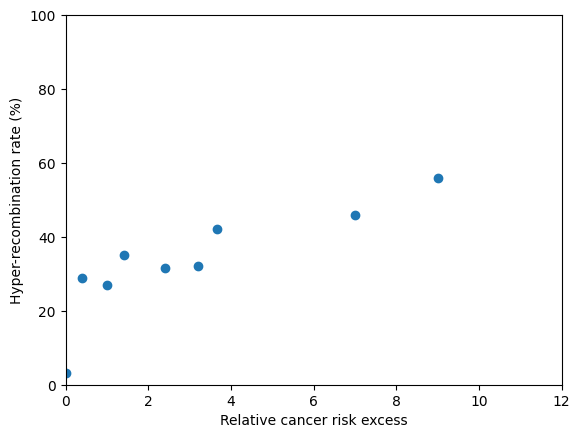

In [4]:
err = data_frame.RR - 1
plt.scatter(err, data_frame.Plasmide)
plt.xlabel("Relative cancer risk excess")
plt.ylabel("Hyper-recombination rate (%)")
plt.xlim(0,12)
plt.ylim(0, 100)
plt.show()

### Modélisation de la dérivée de taux d'hyper-recombinaison

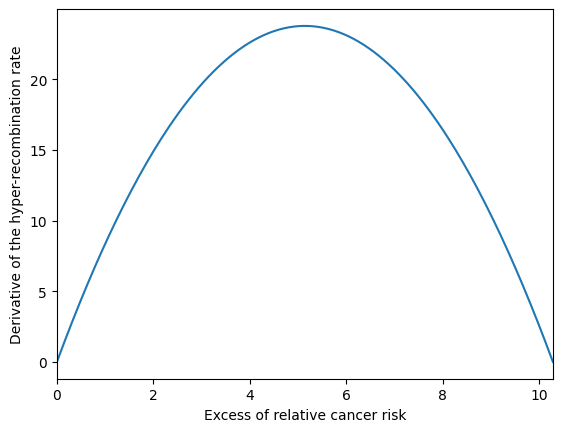

In [17]:
k1 = 0.9
errs = 10.28
k0 = (k1 * errs **2) / 4
excess_relative_cancer_risk = np.linspace(0, errs, 200).reshape(-1, 1)
derivative_hyper_recombination_rate = k1 * excess_relative_cancer_risk * (excess_relative_cancer_risk - errs)

plt.plot(excess_relative_cancer_risk, derivative_hyper_recombination_rate)
# plt.ylim(0, 100)
plt.xlim(0, errs)
plt.xlabel("Excess of relative cancer risk")
plt.ylabel("Derivative of the hyper-recombination rate")
plt.show()

### Modélisation du taux d'hyper-recombinaison
$N(ERR) = \frac{c_1}{3} ERR^3 -  \frac{c_1 ERR_0}{2} ERR^2 + \frac{c_1 ERR_s^2}{4} ERR + n_0$
- $n_0$ constante d'intégration obtenue grâce à la condition $N(0) = 0$, $n_0 = 0$

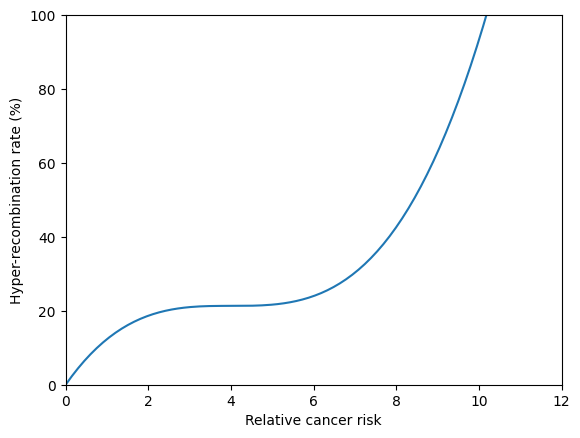

In [52]:
hyper_recombination_rate = (k1 / 3) * excess_relative_cancer_risk**3 - (errs / 2) * k1 * excess_relative_cancer_risk**2 + k1 * (errs**2 / 4) * excess_relative_cancer_risk

plt.plot(excess_relative_cancer_risk, hyper_recombination_rate)
plt.xlim(0,12)
plt.ylim(0, 100)
plt.xlabel("Relative cancer risk")
plt.ylabel("Hyper-recombination rate (%)")
plt.show()

### Inférence des paramètres
#### Avant

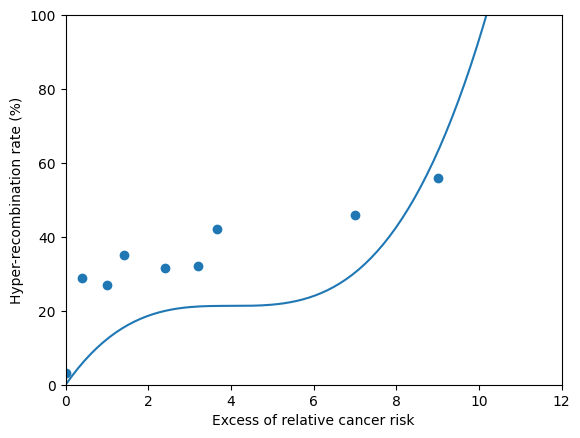

In [53]:
plt.scatter(err, data_frame.Plasmide)
plt.plot(excess_relative_cancer_risk, hyper_recombination_rate)

plt.xlim(0,12)
plt.ylim(0, 100)
plt.xlabel("Excess of relative cancer risk")
plt.ylabel("Hyper-recombination rate (%)")
plt.show()

#### Après

Coefficients estimés: c1 = 0.8950515966009239
D = 10.461834066039563



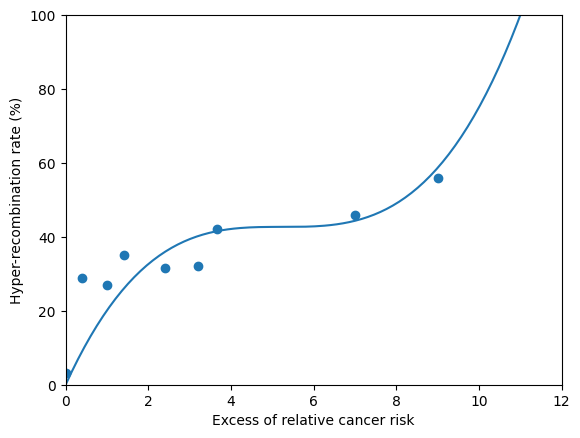

In [61]:
def get_hyper_recombination_rate(err, c1, errs):
    return (c1 / 3) * err**3 - (c1 * errs / 2) * err**2 + (c1 * errs**2 / 4) * err

initial_parameters_polynomial = [0.7, 12]

fitted_parameters_constrained, fitted_cov = curve_fit(get_hyper_recombination_rate, err, data_frame.Plasmide, p0=initial_parameters_polynomial)

c1_fitted, errs_fitted = fitted_parameters_constrained

print(f"Coefficients estimés: c1 = {c1_fitted}\nD = {errs_fitted}\n")

hyper_recombination_fitted = get_hyper_recombination_rate(excess_relative_cancer_risk, c1_fitted, errs_fitted)
    
plt.scatter(err, data_frame.Plasmide)
plt.plot(excess_relative_cancer_risk, hyper_recombination_fitted)
plt.xlim(0,12)
plt.ylim(0, 100)
plt.xlabel("Excess of relative cancer risk")
plt.ylabel("Hyper-recombination rate (%)")
plt.savefig("FIGURES/hyper_recombination_rate.png")
plt.show()

## Taux d'évasion du cycle G2/M
$\frac{dG}{dR} = c_2 G (1 - \frac{G}{K})$

Soit :<br>
$G(R) = K(1 + (\frac{K}{g_0} - 1) e^{-c_2 R})^{-1}$
- $c_2$ constante, raideur de la fonction logistique
- $K$ capacité limite, pourcentage maximal d'évasion
- $g_0$ pourcentage d'évasion pour les syndromes du groupe $I$ 

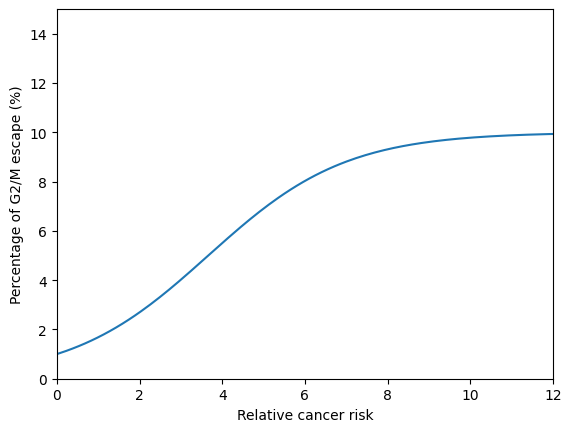

In [15]:
K = 10
g0 = 1
c2 = 0.6
g2m_escape = K / (1 + (K / g0 - 1) * np.exp(-c2 * (excess_relative_cancer_risk)))

plt.plot(excess_relative_cancer_risk, g2m_escape)
plt.ylim(0, 15)
plt.xlim(0, 12)
plt.ylabel("Percentage of G2/M escape (%)")
plt.xlabel("Excess of relative cancer risk")
plt.show()

### Inférence des paramètres

Coefficients estimés: K = 10.985265585271629
g0 = 0.8654820917184781
c2 = 0.5473673168121312


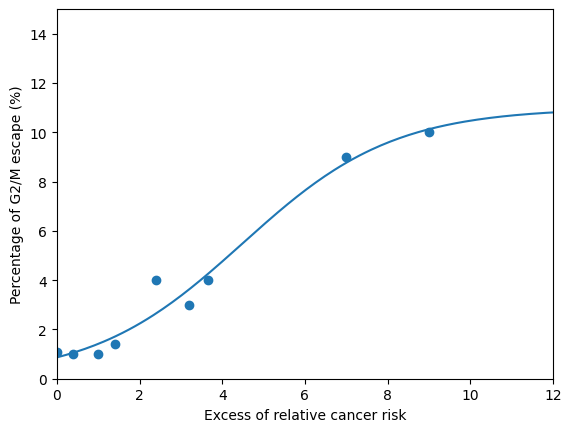

In [60]:
def logistic_func(x, k, x0, c):
    return k / (1 + (k / x0 - 1) * np.exp(-c * (x)))

initial_parameters_guess = [10, 1, 0.6]

fitted_parameters, pcov = curve_fit(logistic_func, err, data_frame["G2/M"], p0=initial_parameters_guess)

K_fitted, g0_fitted, c2_fitted = fitted_parameters

print(f"Coefficients estimés: K = {K_fitted}\ng0 = {g0_fitted}\nc2 = {c2_fitted}")

g2m_escape_fitted = logistic_func(excess_relative_cancer_risk, K_fitted, g0_fitted, c2_fitted)
    
plt.scatter(err, data_frame["G2/M"])
plt.plot(excess_relative_cancer_risk, g2m_escape_fitted)
plt.xlim(0,12)
plt.ylim(0, 15)
plt.xlabel("Excess of relative cancer risk")
plt.ylabel("Percentage of G2/M escape (%)")
plt.savefig("FIGURES/g2m_escaped_rate.png")
plt.show()

- $K = 10.985$
- $g_0 = 0.8655$
- $c_2 = 0.547$

## Produit du taux d'hyper-recombinaison et du taux d'évasion
$(G \times N)(R) = K (\frac{c_1}{3} R^3 -  \frac{c_1 D}{2} R^2 + \frac{c_1 D^2}{4} R + n_0) ((\frac{K}{g_0} - 1) e^{-c_2 R})^{-1}$

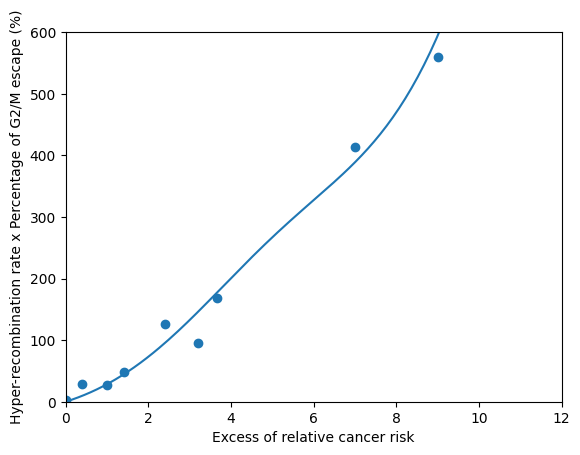

In [64]:
product = hyper_recombination_fitted * g2m_escape_fitted

plt.scatter(err, data_frame["G2/M"] * data_frame.Plasmide)
plt.plot(excess_relative_cancer_risk, product)
plt.ylim(0, 600)
plt.xlim(0, 12)
plt.ylabel("Hyper-recombination rate x Percentage of G2/M escape (%)")
plt.xlabel("Excess of relative cancer risk")
plt.savefig("FIGURES/recombination_x_g2m_escape.png")
plt.show()